In [2]:
import json
import os
import urllib
def download_and_load_file(file_path):
    with open(file_path, "r") as file:
        data = json.load(file)
    return data

file_path = "instruction-data.json"
data = download_and_load_file(file_path)
print("Number of entries:", len(data))

Number of entries: 1100


In [2]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [3]:
def format_input(entry):
    instruction_text = (f"Below is an instruction that describes a task. "
                        f"Write a response that appropriately completes the request."
                        f"\n\n### Instruction:\n{entry['instruction']}"
                        )
    input_text = (f"\n\n### Input:\n{entry['input']}" if entry["input"] else "")
    return instruction_text + input_text

In [4]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [5]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


In [6]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion
train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


In [7]:
import torch
from torch.utils.data import Dataset
class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(tokenizer.encode(full_text))

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [8]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [9]:
def custom_collate_draft_1(batch, pad_token_id=50256, device="cpu"):
    batch_max_length = max(len(item)+1 for item in batch)
    print(batch_max_length)
    inputs_lst = []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (new_item + [pad_token_id] * (batch_max_length - len(new_item)))
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [10]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (
    inputs_1,
    inputs_2,
    inputs_3
    )
print(custom_collate_draft_1(batch))

6
tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [11]:
def custom_collate_draft_2(batch, pad_token_id=50256, device="cpu"):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (new_item + [pad_token_id] * (batch_max_length - len(new_item)))
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        inputs_lst.append(inputs)
        targets_lst.append(targets)
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [12]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [13]:
def custom_collate_fn(batch, pad_token_id=50256, ignore_index=-100, allowed_max_length=None, device="cpu"):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        padded = (new_item + [pad_token_id] * (batch_max_length - len(new_item)))
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]
        inputs_lst.append(inputs)
        targets_lst.append(targets)
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [14]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [15]:
logits_1 = torch.tensor(
        [[-1.0, 1.0],
        [-0.5, 1.5]]
        )
targets_1 = torch.tensor([0, 1]) 
loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


In [16]:
logits_2 = torch.tensor(
                        [[-1.0, 1.0],
                        [-0.5, 1.5],
                        [-0.5, 1.5]]
                        )
targets_2 = torch.tensor([0, 1, 1])
loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


In [17]:
targets_3 = torch.tensor([0, 1, -100])
loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if torch.backends.mps.is_available():
# device = torch.device("mps")"
print("Device:", device)

Device: cuda


In [19]:
from functools import partial
customized_collate_fn = partial(
        custom_collate_fn,
        device=device,
        allowed_max_length=1024
    )

In [20]:
from torch.utils.data import DataLoader
num_workers = 0
batch_size = 8
torch.manual_seed(123)
train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        collate_fn=customized_collate_fn,
        shuffle=True,
        drop_last=True,
        num_workers=num_workers
    )

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        collate_fn=customized_collate_fn,
        shuffle=False,
        drop_last=False,
        num_workers=num_workers
    )

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        collate_fn=customized_collate_fn,
        shuffle=False,
        drop_last=False,
        num_workers=num_workers
    )

In [21]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

2025-05-27 09:24:02.379350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748318042.809116   11370 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748318042.930325   11370 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748318043.856853   11370 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748318043.856925   11370 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748318043.856940   11370 computation_placer.cc:177] computation placer alr

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)
tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])
tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
Mean:
 tensor([[0.132

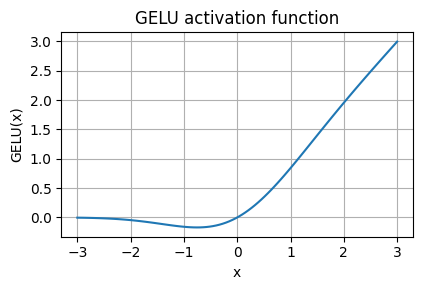

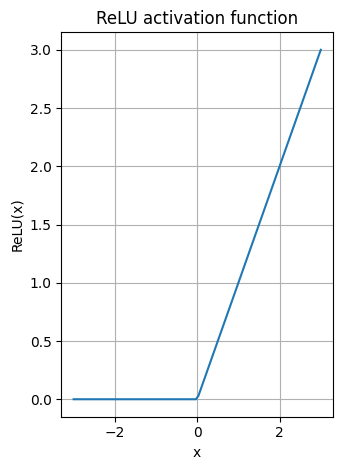

torch.Size([2, 3, 768])
layers.0.0.weight has no gradient (param.grad is None)
layers.1.0.weight has no gradient (param.grad is None)
layers.2.0.weight has no gradient (param.grad is None)
layers.3.0.weight has no gradient (param.grad is None)
layers.4.0.weight has gradient mean of 0.320066
layers.0.0.weight has no gradient (param.grad is None)
layers.1.0.weight has no gradient (param.grad is None)
layers.2.0.weight has no gradient (param.grad is None)
layers.3.0.weight has no gradient (param.grad is None)
layers.4.0.weight has gradient mean of 0.320066
tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])
Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)
tensor([0.4419, 0.6515, 0.5683])
tensor([0.0596, 0.0208, 0.1233])
tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.

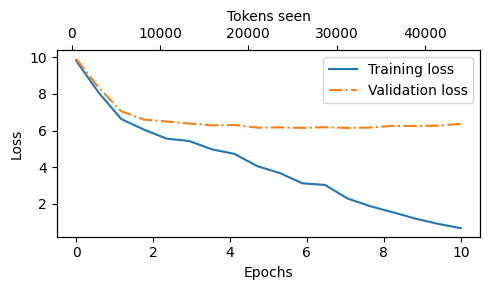

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"


forward
toward
71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you
Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])
tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])
Output text:
 Every effort moves you know began to go a hint a littleoms he painted with a single enough


<string>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
<string>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which us

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe
Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0

checkpoint: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77.0/77.0 [00:00<00:00, 96.9kiB/s]
encoder.json: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.04M/1.04M [00:13<00:00, 77.1kiB/s]
hparams.json: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91.0/91.0 [00:00<00:00, 56.8kiB/s]
model.ckpt.data-00000-of-00001: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.42G/1.42G [2:14:55<00:00, 175kiB/s]
model.ckpt.index: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10.4k/10.4k [00:00<00:00, 6.87MiB/s]
model.ckpt.meta: 100%|█████████████████████████████████████████████████████

In [22]:
from gpt_download import download_and_load_gpt2
import import_ipynb
from chamodel_building import GPTModel
from pretrain_model import load_weights_into_gpt
BASE_CONFIG = {
        "vocab_size": 50257,
        "context_length": 1024,
        "drop_rate": 0.0,
        "qkv_bias": True
    }
model_configs = {
        "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
        "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
        "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
        "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25}
    }
CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

In [23]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [24]:
from pretrain_model import generate, text_to_token_ids, token_ids_to_text
token_ids = generate(model=model, idx=text_to_token_ids(input_text, tokenizer), 
                     max_new_tokens=35, context_size=BASE_CONFIG["context_length"], eos_id=50256,)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [25]:
print(generated_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


In [26]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


In [27]:
from pretrain_model import (calc_loss_loader, train_model_simple)

In [30]:
device = "cpu"

In [31]:
model.to(device)
torch.manual_seed(123)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.8258957386016847
Validation loss: 3.7619208812713625


In [32]:
import time
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)
num_epochs = 2
train_losses, val_losses, tokens_seen = train_model_simple(model, train_loader, val_loader, optimizer, 
                                                           device,num_epochs=num_epochs, eval_freq=5, eval_iter=5,
                                                           start_context=format_input(val_data[0]), tokenizer=tokenizer)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.102
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.945
Ep 1 (Step 000015): Train loss 0.856, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.753, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.798, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.808
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.790
Ep 1 (Step 000050): Train loss 0.662, Val loss 0.783
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.764
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.652, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.532, Val loss 0.729
Ep 1 (Step 000075): Train loss 0.569, Val loss 0.729
Ep 1 (Step 000080): Train loss 0.605, Val loss 0.725
Ep 1 (Step 000085): Train loss 0.509, Val loss 0.709
Ep 1 (Step 000090): Train loss 0.562, Val loss

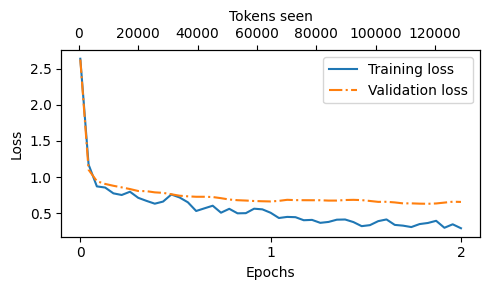

In [33]:
from pretrain_model import plot_losses
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [35]:
torch.manual_seed(123)
for entry in test_data[:3]:
    input_text = format_input(entry)
    token_ids = generate(model=model, idx=text_to_token_ids(input_text, tokenizer).to(device),
                        max_new_tokens=256,context_size=BASE_CONFIG["context_length"],eos_id=50256)
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (generated_text[len(input_text):].replace("### Response:", "").strip())
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prej

In [37]:
from tqdm import tqdm
for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)
    token_ids = generate(model=model,idx=text_to_token_ids(input_text, tokenizer).to(device),
                         max_new_tokens=256,context_size=BASE_CONFIG["context_length"],eos_id=50256)
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (generated_text[len(input_text):].replace("### Response:", "").strip())
    test_data[i]["model_response"] = response_text
with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [06:30<00:00,  3.55s/it]


In [38]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a bullet.'}


In [39]:
import re
file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-medium355M-sft.pth


In [41]:
model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

/tmp/ipykernel_11370/3973947570.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))


<All keys matched successfully>

In [42]:
import psutil
def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

In [43]:
ollama_running = check_if_running("ollama")
if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [44]:
def query_model(prompt,model="llama3",url="http://localhost:11434/api/chat"):
    data = {
        "model": model,
        "messages": [
                    {"role": "user", "content": prompt}
                    ],
        "options": {
                    "seed": 123,
                    "temperature": 0,
                    "num_ctx": 2048
                    }
        }
    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(url,data=payload,method="POST")
    request.add_header("Content-Type", "application/json")
    response_data = ""
    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]
    return response_data

In [45]:
model = "llama3"
result = query_model("What do Llamas eat?", model)
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in many llama diets.
3. Grains: Oats, barley, and corn are common grains that llamas enjoy.
4. Fruits and vegetables: Llamas may also eat fruits like apples, carrots, and sweet potatoes, as well as leafy greens like kale and spinach.
5. Minerals: Llamas need access to minerals like calcium, phosphorus, and salt to stay healthy.

In the wild, llamas might also eat:

1. Leaves: They'll munch on leaves from trees and shrubs, like willow or cedar.
2. Bark: In some cases, they may eat the bark of certain trees, like aspen or birch.
3. Mosses: Llamas have been known to graze on mosses that grow in their natural habitats.

In captivity, llama owners typically provide a balanced diet that includes a 

In [46]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
>> I'd rate the model response "The car is as fast as a bullet." an 85 out of 100.

Here's why:

* The response uses a simile correctly, comparing the speed of the car to something else (in this case, a bullet).
* The comparison is relevant and makes sense, as bullets are known for their high velocity.
* The phrase "as fast as" is used correctly to introduce the simile.

The only reason I wouldn't give it a perfect score is that some people might not immediately think of a bullet when they hear "fast", whereas lightning is often an intuitive comparison for speed. However, "a bullet" is still a good choice and effectively conveys the idea that the car is very fast!

-------------------------

Dataset response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.


In [48]:
def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score."
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
        continue
    return scores

In [49]:
scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [07:22<00:00,  4.02s/it]

Number of scores: 110 of 110
Average score: 47.88

